# Mega StratBuilder

This is the neatened StratBuilder code with some of my annoying essays. The main draw of this code is that it houses the components to interpret cross-stream and down stream sections, you just have to declare it. This code works by importing the full grids from NAYS2DH as a NumPy array and pulling out the model results for a specified location. It basically functions in 3 parts:
1. Data import
2. Plotting
3. Exports and some preliminary statistics

## Declare cross-stream or downstream flags

In [1]:
sec_flag = input('What kinds of sections are you plotting: XS or DWN: ')

What kinds of sections are you plotting: XS or DWN:  DWN


## Import packages

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import copy
import os

from os import listdir
from os.path import isfile, join
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.signal import savgol_filter


In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

##### Setting up all the aesthetics:
Import new colormapas, reverse them, create plot style (font, font size, etc)

In [3]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)
kwargs = dict(edgecolor = 'k', fc = 'xkcd:greyish', alpha=0.5, bins=20)

In [4]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcol.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [5]:
test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','069af3', '0e87cc', '2242c77', '0504aa', '00035b'] 


In [6]:
class MidpointNormalize(mcol.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        mcol.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [7]:
def line_eq(x, y):
    '''calculate components of gradient of a line'''
    grads = (y[1:]-y[:-1])/(x[1:]-x[:-1])
    ints = y[:-1]-(grads*x[:-1])
    dists = (((x[1:]-x[:-1])**2)+((y[1:]-y[:-1])**2))**0.5
    theta = np.arctan((y[1:]-y[:-1])/(x[1:]-x[:-1]))
    
    return (grads, ints, dists, theta)

### Important model parameters that might be used in calculation + import data:
At the moment (March 22) the only things we need to set are:
1. cross-section location (I and J)
1. DV flag (0 for none, 1 for variable)
1. adjustment time (60 for the 2 hour strat given an average adj time of 120 hours)

Need to expand and change cell width and length if not using a 4x10 cell size!

In [8]:
Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m
morfac = 25
thot_SS = 0 # 802800
#time from which we restarted the runs to add a flood
fldstart_s = 802800 ###start time of flood in seconds
variabd = 0 #int(input('Enter DV flag: ')) #flag for if in variable discharge regime
adjustment_time = 65 #int(input('Enter bed adjustment time here, be wary of timestep conversion: ')) #number of timesteps, in hours taken for bed to equilibrate

fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}-flux.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s

print(f'/Volumes/SAF_Data/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

iloc = 340 #int(input('I-location is '))#location of the section along i axis
jloc = 0 #int(input('j-location is '))#location of the secion along j axis


/Volumes/SAF_Data/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour-flux.npy


In [9]:
cellW = 4
cellL = 10
xloc = iloc*cellL
xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

savefilesto = '/Volumes/SAF_Data/NAYS2DH_files/Plots/'
modelrun = f'{nickname}-{idf}-{iloc}'

In [10]:
###define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

print('Shape of the datamaster dataset is: ', datamaster.shape)

Shape of the datamaster dataset is:  (26026, 12, 382)


In [11]:
num_timesteps = datamaster.shape[2] ##### or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ###when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ###flood starttime, s
skipstep = 12 #number of outputs you skipped in datamaster, every 2 hours generally
print('Shape of data used to plot:', datamaster.shape)

Number of timesteps being used:  382
Shape of data used to plot: (26026, 12, 382)


### Model-real time converter

[0.07764493 0.22187405 0.2313765  2.02914702]
attribute top: 0.65. Midpoint: 0.42


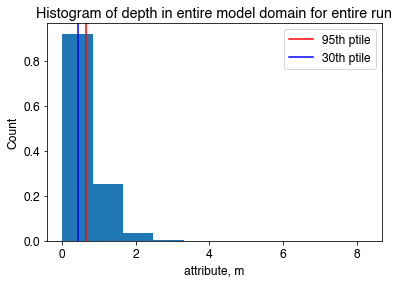

In [12]:
#plt.figure(figsize = (30, 20))
char = 10 ##### what do you want to colour by? flow depth (4), elevation change (7) etc
attribs = datamaster[:, char, :].ravel() # scaling to find your normalisation for the attribute/char you choose to colour with
avattribs = np.average(attribs)
locd = np.average(avattribs)
scd = np.std(avattribs)
attx = np.linspace(attribs.min(), attribs.max())
# apdf = stats.norm.pdf(attx, locd, scd)
plt.hist(attribs, density=True);

toplim = np.quantile(attribs, 0.65)
lowlim = np.quantile(attribs, 0.45)
discrete_vel = np.quantile(attribs, (0.1, 0.25, 0.26, 0.99))
print(discrete_vel)
#plt.figure(figsize = (30, 20))
plt.axvline(toplim, c = 'r', label = '95th ptile')
plt.axvline(lowlim, c = 'b', label = '30th ptile')
plt.xlabel('attribute, m')
plt.ylabel('Count')
plt.legend()

plt.title('Histogram of depth in entire model domain for entire run');
print(f'attribute top: {np.round(toplim, 2)}. Midpoint: {np.round(lowlim, 2)}')

In [13]:
char = 10
xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
elev_final = np.reshape(datamaster[:, char, -1], (gridy, gridx)) ###using flow depth to plot
midnorm = MidpointNormalize(vmin=0, vcenter=lowlim, vmax=toplim) 


### Now begin developing the sections 
### DO NOT TOUCH THIS CELL

Upstream limit of the reach, in km:  3000
Downstream limit of the reach, in km:  4000
skip every how many timesteps:  10


0.0


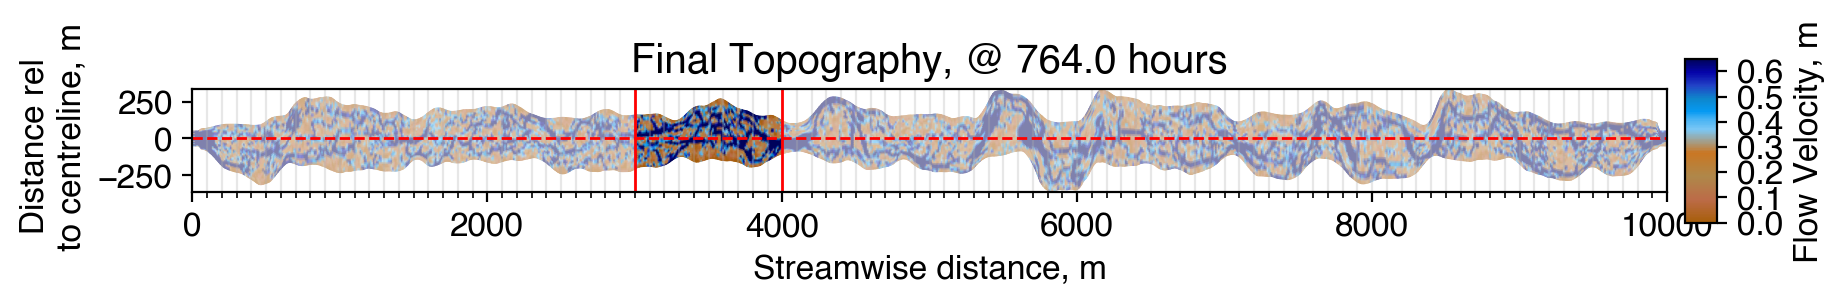

In [14]:
if sec_flag == 'DWN': 
    upstream = int(input('Upstream limit of the reach, in km: '))
    downstream = int(input('Downstream limit of the reach, in km: '))
    step = int(input('skip every how many timesteps: '))
    modelrun = f'{nickname}-hr-{fldlength}hrfld-{upstream/10}-{downstream/10}'
    
    ### DEFINE REACH TO PLOT ###
    
    centreline = np.floor(np.average(abs(datamaster[:, 3, :]).min(axis = 0))) ##change this if you want a different section location
    print(centreline)

    fig, ax = plt.subplots(1, figsize = (10, 2), tight_layout = True, dpi = 200, sharex = True)
    #ax.set_xlim(upstream, downstream)
    ax.set_ylabel('Distance rel \n to centreline, m')
    ax.set_xlabel('Streamwise distance, m')

    ax.set_title(f'Final Topography, @ {end_t*interval_to_plot} hours')
    ylims = np.array([datamaster[:, 3, -1].min(),datamaster[:, 3, -1].max()])

    ax.axhline(centreline, c = 'r', ls = '--', lw = 1)
    ax.axvline(upstream, c = 'r', ls = '-', lw = 1)
    ax.axvline(downstream, c = 'r', ls = '-', lw = 1)
    dat_final = ax.pcolormesh(xdomain, ydomain, elev_final, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)

    ax.fill_betweenx(ylims, [0, 0], [upstream, upstream], fc = 'w', alpha =.5)
    ax.fill_betweenx(ylims, [downstream, downstream], [datamaster[:, 2, -1].max(), datamaster[:, 2, -1].max()], fc = 'w', alpha =.5)

    fig.colorbar(dat_final, ax = ax, label = 'Flow Velocity, m', pad = 0.01, shrink = 0.5, aspect = 5)

    ax.set_aspect('equal')
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.grid(axis = 'x', which = 'both', alpha = 0.3)
    #plt.close(fig)

    ### NOW CROP THE DATA ###
    uend = upstream/10
    dend = downstream/10

    section_thresh = 1 #threshold distance around the transect to take data from

    remove_ilocs = np.where(np.logical_or(datamaster[:, 2, :]< upstream, datamaster[:, 2, :]> downstream))
    data = np.delete(datamaster, remove_ilocs[0], axis=0)


    ### 2D INTERPOLATIO OF GRIDS BEFORE EXTRAOLATING SECTION TRANSECT

    ## set the grid dimensions as the dimentions of the original rectangular grid so that we are sure to 
    ## extract full sections

    rbound = data[:, 3, 0].max() # right bound is positive, left negatice
    lbound = data[:, 3, 0].min()

    interplevel = 1 # we want to the spacing to be 0.5. This value is in metres
    grid_x, grid_y = np.mgrid[upstream:downstream:interplevel, lbound:rbound:interplevel] #create x and y grids

    ### NOW INTERPOLATE ALONG SECTION

    xy_topo = np.empty([grid_x.shape[0], grid_x.shape[1], end_t])
    sh = np.empty_like(xy_topo)
    fr = np.empty_like(xy_topo)
    dep = np.empty_like(xy_topo)
    vel = np.empty_like(xy_topo)
    qb = np.empty_like(xy_topo)

    for t in range (adjustment_time, end_t, step):
    # for t in range (end_t-1, end_t, step):
        points = data[:, 2:4, t] #the points are the x and y locations in metres, so a 2D array of XY locs

        elevvals = data[:, 7, t] #the values are the variables you want, 7 for elevation change
        shearvals = data[:, 6, t] #the values are the variables you want
        depthvals = data[:, 4, t] #the values are the variables you want
        froudevals = data[:, 9, t] #the values are the variables you want
        velvals = data[:, 10, t] #the values are the variables you want
        qbvals = data[:, 11, t]

        xy_topo[:, :, t] = griddata(points, elevvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
        sh[:, :, t] = griddata(points, shearvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
        dep[:, :, t] = griddata(points, depthvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
        fr[:, :, t] = griddata(points, froudevals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
        vel[:, :, t] = griddata(points, velvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
        qb[:, :, t] = griddata(points, qbvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 

        if t==100:
            print("It is running gurl, b patient")
        if t==200:
            print('Getting there, almost done')
        if t==end_t-1:
            print('Okay, fin!!')

    rawstrat = copy.deepcopy(xy_topo)

    ## now we have to pull out the data arrays for the section only, in the traditional shape ([time, xlocation])

    xlocs = np.empty([grid_x.shape[0], end_t])
    xlocs = grid_x[np.where(grid_y==centreline)]
    xy_strat = xy_topo[np.where(grid_y==centreline)].T
    shear = sh[np.where(grid_y==centreline)].T
    froude = fr[np.where(grid_y==centreline)].T
    trueflow = dep[np.where(grid_y==centreline)].T
    #flowvel = vel[np.where(np.floor(grid_y)==centreline)].T ## just oin case the line doesnt work
    flowvel = vel[np.where(grid_y==centreline)].T
    bedflux = qb[np.where(grid_y==centreline)].T
    xy_topo = copy.deepcopy(xy_strat)
    
elif sec_flag == 'XS':


    ###Crop and sort the data by jloc (removing ilocs that are not the desired section) so its in section order and not streamwise

    #crop data
    remove_ilocs = np.where(datamaster[:, 0, :] != iloc)
    data = np.delete(datamaster, remove_ilocs[0], axis=0)
    print('Cropped, final dataset shape: ', data.shape)

    #sort in cross stream direction from rightbank to left bank
    #test = np.empty_like(datamaster)    
    for i in range (0, num_timesteps):
        data[:, :, i] = data[:, :, i][np.argsort(data[:, :, i][:, 3])]
        #print(i, data[:, 3, i])

    ### Now fill in arrays for elevation, position, shear etc...

    ###Make the arrays to store data
    stratigraphy = np.empty([end_t, cells]) ###will hold data for topography accounting for changes due to erosion
    #print(elevation.shape) #elevation = np.empty([n, end_t])

    # print('Shape of prelim arrays: ', stratigraphy.shape)

    #this matrix is to record unmodified stratigraphy in the same shape as the eroded strat
    stratigraphy_idx = stratigraphy.copy()
    #stratigraphy_idx[:] =  np.nan
    #print(stratigraphy)

    shearstresseroded = stratigraphy.copy() #will hold data for shear stress accounting for changes due to erosion
    #shearstresseroded[:] = np.nan
    #print('!!!', shearstresseroded.shape)

    stratflowdepth =  stratigraphy.copy() #will hold data for flow depth accounting for changes due to erosion
    #stratflowdepth[:] = np.nan

    scaleflowdepth =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
    #scaleflowdepth[:] = np.nan

    froudedata =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
    #froudedata[:] = np.nan

    velocity =  stratigraphy.copy()
    bedloadflux = stratigrahy.copy()
    
    runtime = len(stratigraphy)
    #print(runtime)
    xposition =  stratigraphy.copy()

    in_section = np.where(datamaster[:, 0, -1]==iloc)
    in_section = in_section[0]
    bankpos = datamaster[:, 3, :][in_section]
    #print(bankpos)
    rightbank = bankpos.min() ###negativee
    leftbank = bankpos.max() #positive
    print('Left bank max position: ', leftbank)
    print('Right bank max position: ', rightbank)

    xy_strat = np.empty([end_t, int(3+np.round((leftbank-rightbank)/spacing, 0))]) # will put stratigraphies here, in proper x pos
    print('Shape of stratigraphy matrix:, ', xy_strat.shape)
    xy_strat[:] = np.nan
    # ages = np.empty_like(xy_strat)

    # #### Import, and fill the arrays that will be used for the rest of the code
    # 1. Import data for shear stress, flow depth, velocity and froude
    # 2. Interpolate data to represent actual channel dimensions and not grid dimensions
    # 3. Fill and remove any remaining nans from the arrays

    ##### Import the data
    for time in range (0, data.shape[2]): #TIME
        #print(stratigraphy[time, :].shape)
        stratigraphy[time, :] = data[:, 7, time] #elevation change, elevation in 5
        shearstresseroded[time, :] = data[:, 6, time] 
        stratflowdepth[time, :] = data[:, 4, time]
        froudedata[time, :] = data[:, 9, time]
        velocity[time, :] = data[:, 10, time]
        bedloadflux[time, :] = data[:, 11, time]

        ypos = data[:, 3, time]-rightbank #coreect supid centreline indexing
        #print(ypos)
        xposition[time, :] = ypos

    stratigraphy_idx = stratigraphy.copy()

    ###you need to change the y positions from centreline position to actual positional data
    #print(xposition.max(axis = 1))

    ##### these arrays will house interpolated data
    shear = xy_strat.copy()
    froude = xy_strat.copy()
    scaleflow = xy_strat.copy() #flow depth scaled to max per time
    trueflow = xy_strat.copy() #unscaled flow depth
    flowvel = xy_strat.copy() #flow velocity
    bedflux = xy_strat.copy()

    print('True shape, m: ', shear.shape, froude.shape, scaleflow.shape, trueflow.shape, flowvel.shape)

    #put all data values in their correct x/index position
    for t in range (0, end_t):
        #print(t)
        for idx, x in zip(np.arange(0, stratigraphy.shape[1]), xposition[t, :]):
            #print(x)
            #print(idx, x)
            x = int(np.floor(x)) #rounding down positions, making integers so can use as index
            #print(x, idx)
            xy_strat[t, x] = stratigraphy[t, idx]
            shear[t, x] = shearstresseroded[t, idx]
            froude[t, x] = froudedata[t, idx]
            trueflow[t, x] = stratflowdepth[t, idx]
            scaleflow[t, x] = scaleflowdepth[t, idx]
            flowvel[t, x] = velocity[t, idx]
            bedflux[t, x] = bedloadflux[t, idx]
        #plt.plot(xy_strat[t, :], '.')

    xy_topo = np.empty_like(xy_strat)
    xy_topo[:] = np.nan
    for t in range (0, end_t):
        #print(t)
        length = int(np.floor(xposition[t, -1]-xposition[t, 0])) #length of the section at time, t
        pos = np.linspace(0, length, length) #create a metre scale array with each x pos = location
        #dataint = np.linspace(int(np.round(xposition[t, 0], 0)), int(np.round(xposition[t, -1], 0)), length, dtype=int) #range of locations to interpolate over?
        dataint = np.arange(xposition[t, 0], np.round(xposition[t, -1], 0), dtype=int)
        #print(t, pos.max(), length)
        #print(len(dataint))
        #print(pos)

        stratnotnan = xy_strat[t, :][~np.isnan(xy_strat[t, :])] #pull out real values of strat
        shearnotnan = shear[t, :][~np.isnan(shear[t, :])] #pull out real values of shear
        froudenotnan = froude[t, :][~np.isnan(froude[t, :])] #pull out real values of froude
        truefnotnan = trueflow[t, :][~np.isnan(trueflow[t, :])] #pull out real values of true flow depth
        #scalefnotnan = scaleflow[t, :][~np.isnan(scaleflow[t, :])] #pull out real values of scaled flow depth
        velnotnan = flowvel[t, :][~np.isnan(flowvel[t, :])] #pull out real values of strat
        qbnotnan = bedflux[t, :][~np.isnan(bedflux[t, :])]
        #print(shear[t, :][~np.isnan(shear[t, :])])
        #print(shearnotnan[:].shape, froudenotnan[:].shape, truefnotnan[:].shape, velnotnan[:].shape)
        #print(xposition[t, :])
        #print(dataint)
        fx = interpolate.interp1d(xposition[t, :], stratnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #stratigraphy interpolation
        #print(fx)
        fsh = interpolate.interp1d(xposition[t, :], shearnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #shear stress interpolation
        ffr = interpolate.interp1d(xposition[t, :], froudenotnan[:], kind = 'cubic', fill_value = 'extrapolate') #froude number interpolation
        ftf = interpolate.interp1d(xposition[t, :], truefnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #true flow depth interpolation
        #fsf = interpolate.interp1d(xposition[t, :], scalefnotnan[:], kind = 'cubic') #scaled flow depth interpolation
        ffv = interpolate.interp1d(xposition[t, :], velnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #flow veloity interpolation
        fqb = interpolate.interp1d(xposition[t, :], qbnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #bedload flux interpolation
        #print(fx(dataint))

        xy_topo[t, dataint] = fx(dataint) #reassign strat
        #print(xy_topo[t, :])
        shear[t, dataint] = fsh(dataint) #reassign shear
        froude[t, dataint] = ffr(dataint) #reassign froude
        trueflow[t, dataint] = ftf(dataint) #reassign true fd
        #scaleflow[t, 0:length] = fsf(pos) #reassign scaled fd
        flowvel[t, dataint] = ffv(dataint) #reassign flow vel
        bedflux[t, dataint] = fqb(dataint)

        #plt.plot(xy_topo[t, :])
    #plt.ylim(-3, 3)

In [15]:
xswidths = ydomain[-1, :]-ydomain[0, :]

(1001, 382)

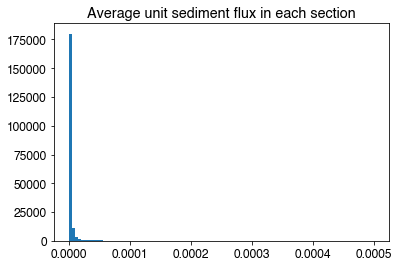

In [16]:
### find the average unit sediment flux across each cross-section location to calculate the turntime

bedflux_grid = np.reshape(datamaster[:, -1, :], (gridx, gridy, end_t)) ## make a bed shaped grid of bedload flux

## remove sed flux values where its above water (below a depth threshold)
bedflux_grid[np.reshape(datamaster[:, 4, :], (gridx, gridy, end_t)) < np.nanquantile(trueflow[-1, :], 0.01)] = np.nan 

## find the cross section averaged sed flux in each cell
unit_qs_xs = np.divide(np.sum(bedflux_grid, axis = 1), np.reshape(xswidths, (gridx, 1)))
plt.hist((unit_qs_xs).ravel(), bins = 100, density =True);
# plt.hist(np.sum(bedflux_grid, axis = 1).ravel(), histtype = 'step')
plt.title('Average unit sediment flux in each section')
unit_qs_xs.shape
# plt.xlim(0, 2000)

In [17]:
#new cell 2023!!!--update 2024, i scrapped the interpolation method bc the values were too small, just using the cross section averaged unit seciment flux (sum of qs divided my xs width)
unit_bf = copy.deepcopy(bedflux)
unit_bf[trueflow < np.nanquantile(trueflow[-1, :], 0.01)] = np.nan ## remove where bedload flux values above water
unit_bf[unit_bf<0] = np.nan

Text(0.5, 1.0, 'Celllular bedfload flux along stream wise reach')

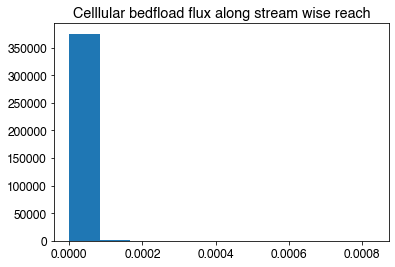

In [18]:
plt.hist(unit_bf.ravel());
plt.title('Celllular bedfload flux along stream wise reach')

In [19]:
rows4tt = np.unique(np.where(np.isnan(xy_strat))[0])
initarr = xy_strat[rows4tt[0], :]

for i in rows4tt[1:]:
    initarr = np.vstack((initarr, xy_strat[i, :]))
    

In [20]:
#each of these conditional arrays have a border of nans to helo pick out the 'packages'
stratcondition = np.zeros_like(xy_topo)
stratcondition[:] = np.nan
ages = np.empty_like(xy_strat)


erosurf = np.empty([end_t, xy_topo.shape[1]])
erosurf[:] = np.nan


In [21]:
#adjustment_time = 120
#fig, ax = plt.subplots(time//adjustment_time, 2, tight_layout = True, figsize = (5, 4), dpi=200)
#fig.subplots_adjust(wspace = 0.001)
strat = copy.deepcopy(xy_topo)

halfwidth=25

for time in range (0, end_t):
    #plt.plot(stratigraphy[time]) #this is just a check to make sure youre importing the data correctly
    
    #now we have stratigraphy at each timestep with time on the j axis and position on the i
    #we want to check each location at each timestep for areas that have erodible elevation (i.e. higher than current timestep)
    
    for space in range (0, xy_topo.shape[1]):
        #print(space)
        preexisting_strata = xy_topo[:time, :] #this is our search array, where we will erode
        #preexisting_strata_idx = stratigraphy_idx[:time, :]
        
        #print(preexisting_strata.shape)
        #print('xy', xy_strat[time, :].shape)
        willerode = np.where(preexisting_strata[:, space] > xy_topo[time, space])
        #print('willerode', willerode)
        
        #print(time, column, willerode)
        
        xy_topo[willerode, space] = xy_topo[time, space]
        ages[willerode, space] = time
        
#     if np.logical_and(time % adjustment_time == 0, time < end_t):
#         axidx = int(time/adjustment_time)-1
#         for adj in range (0, time):
#             ax[axidx, 0].plot(xy_topo[adj, :], 'k', lw=0.1)
#             ax[axidx, 0].set_title(time)
#         ax[axidx, 0].set_xlim(xposition[-1, :].min(), xposition[-1, :].max())
#         ax[axidx, 0].set_ylim(np.nanmin(xy_topo), np.nanmax(xy_topo))
#         #ax[axidx, 0].set_aspect('15')
#         ax[axidx, 1].pcolormesh(np.reshape(datamaster[:, 2, time], (gridy, gridx)), 
#                                 np.reshape(datamaster[:, 3, time], (gridy, gridx)),
#                                 np.reshape(datamaster[:, char, time], (gridy, gridx)),
#                                 cmap = get_continuous_cmap(test), norm = midnorm, 
#                                 shading = 'gouraud', alpha = 1)
#         ax[axidx, 1].set_aspect('equal')
#         ax[axidx, 1].axvline(xsloc, c='r',ls = '--')
        
#         ax[axidx, 1].set_xlim((iloc-halfwidth)*cellL, (iloc+halfwidth)*cellL)
#         ax[axidx, 1].set_ylim(ydomain.min(), ydomain.max())
        #stratigraphy_idx[willerode_idx, column] == np.nan
    #print(stratigraphy_idx[time])
    

#plt.savefig(f'{savefilesto}timeseries/compositestrat-{modelrun}.png', dpi = 100, bbox_inches = 'tight', pad_inches = 0.1)
#plt.ylim(0.1, 4)
    #print('st', stratigraphy)
#print('sh', shearstresseroded)
#print(ages[:5])
##### fill an areas with data 'above it' in the section

if sec_flag == 'XS':
    for i in range (end_t-2, -1, -1):

        fillinx = np.where(np.isnan(xy_topo[i, :]))
        xy_topo[i, fillinx] = xy_topo[i+1, fillinx]
        xy_strat[i, fillinx] = xy_strat[i+1, fillinx]

        #strat[i, fillinx] = strat[i+1, fillinx]
        ##### fill in all filled in areas in the strat condition matrix with the flag for erosion
        stratcondition[i, fillinx] = 1
        #print(stratcondition[i, fillinx])

        fillinsh = np.where(np.isnan(shear[i, :]))
        shear[i, fillinsh] = shear[i+1, fillinsh]

        fillinfr = np.where(np.isnan(froude[i, :]))
        froude[i, fillinfr] = froude[i+1, fillinfr]

        fillintf = np.where(np.isnan(trueflow[i, :]))
        trueflow[i, fillintf] = trueflow[i+1, fillintf]

        fillinsf = np.where(np.isnan(scaleflow[i, :]))
        scaleflow[i, fillinsf] = scaleflow[i+1, fillinsf]

        fillinfv = np.where(np.isnan(flowvel[i, :]))
        flowvel[i, fillinfv] = flowvel[i+1, fillinfv]

        fillinstrat = np.where(np.isnan(strat[i, :]))
        #strat[i, fillinstrat] = strat[i+1, fillinstrat]

    #print('no fill', xy_topo[i, fillin])

    #print('fill', xy_topo[i, fillin])

*Verify that the stratigraphy looks the way it should*

(3000.0, 4000.0)

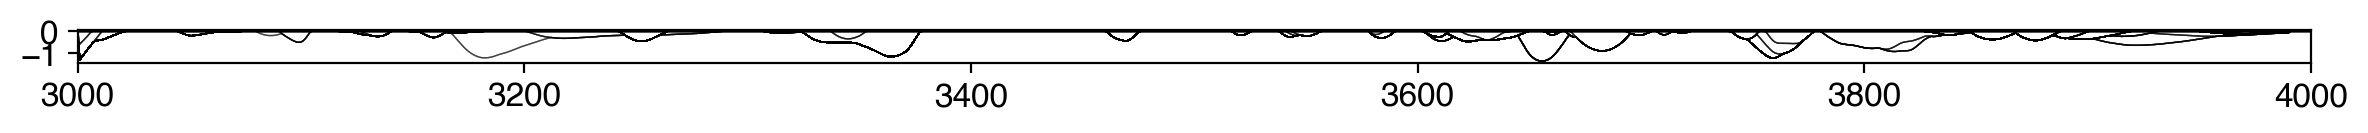

In [22]:
#%matplotlib notebook
fig, ax = plt.subplots(figsize = (12, 3), tight_layout=True, dpi=200)
for i in range(60, end_t):
    ax.plot(np.arange(upstream, downstream), xy_topo[i, :], 'k', alpha = 0.2, lw = 0.5)
ax.set_aspect('10')
ax.set_xlim(upstream, downstream)
# ax.set_xlim(xposition[-1, :].min(), xposition[-1, :].max());
# ax.axvline(abs(data[:, 3, -1]).min()-rightbank, c='b', ls='-.', lw=1)
#plt.savefig(f'{savefilesto}showfig-{iloc}.png', dpi = 200)

In [23]:
ages_ero = np.empty_like(xy_topo)
# posnew = np.arange(0, xy_topo.shape[1])
posnew=np.arange(upstream, downstream)

#### Find turnover timescales in a loop, plot one big histy

In [ ]:
np.nanmean(np.reshape(datamaster[:, -1, :], (gridx, gridy, end_t), order = 'F'), axis = 1).shape

#### How turnover time calculation is computed:

1. Apply SavGol filer to bed elevation (its a regression filter)
2. Find the inflection points on the surface (where the gradient @ i = -ve and i+1 = +v1)
3. Connect consecutive inflection points with a line, get the length of the line 
4. Find max vertical thickness and correct for the dip on the line using trig
5. Find the XS averaged sed fux at that bar head (do this for every bar in the transect, XS avg is computed using the XS width)
6. Calculate turnover timescale: TT = Area/Unit sed flux (convert s to days, add in morfac by dividing by 86400*25)

### USING UNIT SED FLUX AT BAR HEAD

In [24]:
## Define timestep of bed topo of interest 
# t_topo = 381
window = 21
pol_ord = 1
turntimelib = np.array([])
bararealib = np.array([])
bar_heights = np.array([])
bh_sedflux = np.array([]) # sed flux at bar heads through time
xy_strat_tt = np.delete(xy_strat, np.unique(np.where(np.isnan(xy_strat))[1]), axis = 1)
# xsflux_t = np.nanmean(np.reshape(datamaster[:, -1, :], (gridx, gridy, end_t), order = 'F'), axis = 1) ##in m2/s, XS avg flux
for t_topo in rows4tt:
    # moving_topo = savgol_filter(xy_strat_tt[t_topo, :][~np.isnan(xy_strat_tt[t_topo, :])], window, pol_ord, mode = 'interp')
    moving_topo = savgol_filter(xy_strat_tt[t_topo, :], window, pol_ord, mode = 'interp')
    pos_bars = posnew[~np.isnan(xy_strat[t_topo, :])]

#     plt.figure(figsize = (12, 2), dpi = 100)
#     plt.plot(posnew, xy_strat[t_topo, :], 'c-')
#     plt.plot(pos_bars, moving_topo, 'k--')

#     # plt.xlim(1000, 9000)
#     plt.title(f'Bed elevation at time, {t_topo}, and Savitsky-Golay smoothed elevation --, smoothing window = {window}, poly = {pol_ord}, {t_topo}')
# # 
#     ### USING MOVING AVERAGED TOPOGRAPHY
#     plt.figure(figsize = (10, 1), dpi = 200)
    #topo_grad, dips = movinggrad(moving_topo[1:], pos_bars)
    topo_grad = (moving_topo[1:]-moving_topo[:-1])/(pos_bars[1:]-pos_bars[:-1])

    maxima = moving_topo[1:-1][np.logical_and(topo_grad[:-1]>0, topo_grad[1:]<0)]
    minima = moving_topo[1:-1][np.logical_and(topo_grad[:-1]<0, topo_grad[1:]>0)]
    max_xlocs = pos_bars[1:-1][np.logical_and(topo_grad[:-1]>0, topo_grad[1:]<0)]
    min_xlocs = pos_bars[1:-1][np.logical_and(topo_grad[:-1]<0, topo_grad[1:]>0)]


    #insert end points into the array bc previous logic statement doesn't include them
    if topo_grad[0] < 0:
        maxima = np.insert(maxima, 0, moving_topo[1])
        max_xlocs = np.insert(max_xlocs, 0, pos_bars[1])
    if topo_grad[0] > 0:
        minima = np.insert(minima, 0, moving_topo[1])
        min_xlocs = np.insert(min_xlocs, 0, pos_bars[1])

    ## calculate heights
    if len(maxima) == len(minima):
        successive_heights = (maxima-minima)[:-1]
        lengths = min_xlocs[1:]-min_xlocs[:-1]

    elif len(maxima)>len(minima): ## OK
        successive_heights = maxima[1:]-minima
        lengths = min_xlocs[1:]-min_xlocs[:-1]
    else: ##minima > maxima 
        successive_heights = maxima-minima[1:]
        lengths = min_xlocs[1:]-min_xlocs[:-1]

    successive_heights = successive_heights#/25 ### Q 4 LIZ do you actually have to divide by 25? becasue if the channel elevation is being up scaled by 25x with morfac then the output data are for 1/25 of the change?
    bar_heights = np.append(bar_heights, successive_heights[:len(lengths)])
    min_xlocs_pos = (np.round(min_xlocs, -1)/10).astype(int)

#     flux_4calc = unit_qs_xs[min_xlocs_pos, t_topo]#*(86400*25)
#     flux_4calc = xsflux_t[min_xlocs_pos, t_topo]
#     flux_4calc = unit_bf[t_topo, min_xlocs_pos]
    flux_4calc = unit_qs_xs[min_xlocs_pos, t_topo]
    
    bh_sedflux = np.append(bh_sedflux, flux_4calc[:-1])
    turn_time = (successive_heights[:len(lengths)]*lengths*0.5)/flux_4calc[:-1]
    bar_areas = (successive_heights[:len(lengths)]*lengths*0.5)

#     fig, ax = plt.subplots(2, 1, figsize = (10, 4), dpi = 200, tight_layout = True)

#     sns.histplot(turn_time[turn_time>=0]/(86400*25), ax = ax[1], bins = 25)#, bins = 50);

#     ax[0].plot(moving_topo, 'b-', label = 'moving topo')
#     ax[0].scatter(min_xlocs, minima, marker = '*', c = 'r')
#     ax[1].set_title(f'Turnover timescale, for bars, reduced to days acc for morfac, {t_topo}')
    turntimelib = np.append(turntimelib, turn_time)
    bararealib = np.append(bararealib, bar_areas)
    # axs = ax[0].twinx()


In [25]:
ttldays = (turntimelib/(86400*25))

Text(0.5, 1.0, 'Sed flux at bar heads from 3-4km downstream')

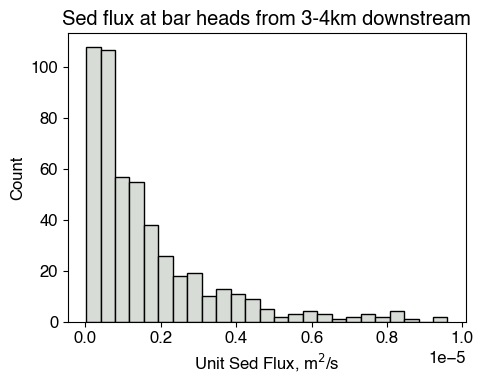

In [26]:
plt.figure(figsize = (5, 4), dpi = 100, tight_layout = True)
plt.hist(bh_sedflux[bh_sedflux<0.00001], bins = 25, ec = 'k', fc = 'xkcd:light grey');
plt.xlabel('Unit Sed Flux, m$^2$/s')
plt.ylabel('Count');
plt.title(f'Sed flux at bar heads from 3-4km downstream')
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/sedflux_barhead.png', dpi = 300)

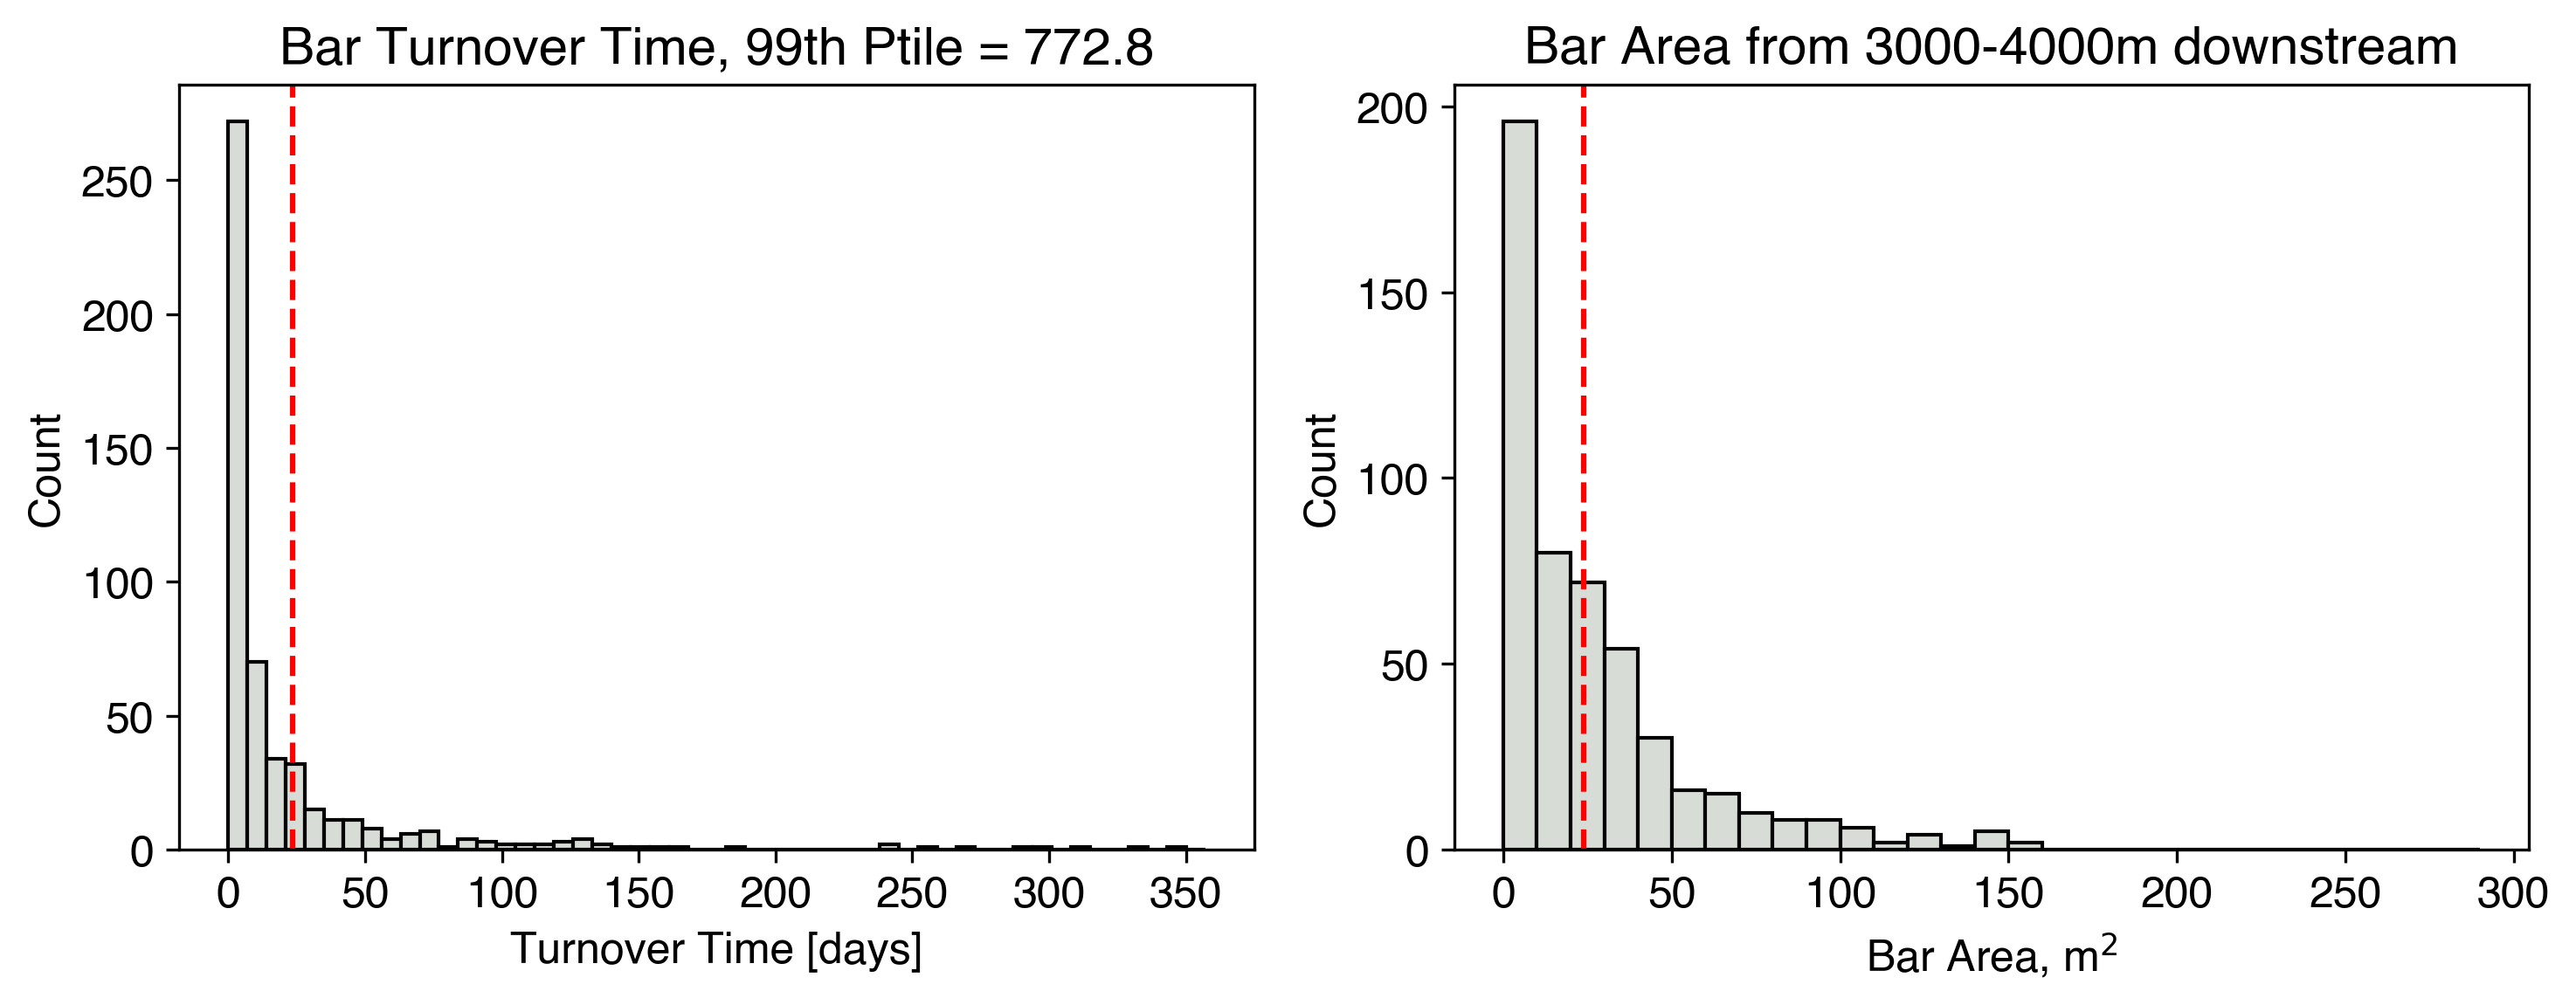

In [27]:
fig, ax = plt.subplots(1, 2, tight_layout = True, figsize = (10, 4), dpi = 300)
ax[0].hist(ttldays[ttldays<np.nanquantile(ttldays, .999)], bins = np.arange(0, 364, 7), ec = 'k', fc = 'xkcd:light grey');
# ax[0].hist(ttlyrs[ttlyrs<3000], bins = np.arange(0, 60, 3), ec = 'k', fc = 'xkcd:light grey');
ax[0].set_xlabel('Turnover Time [days]')
ax[0].set_ylabel('Count');
# ax[0].set_ylim(500, 3000)
ax[0].set_title(f'Bar Turnover Time, 99th Ptile = {np.round(np.nanquantile(ttldays, .999), 1)}')

ax[1].hist(bararealib, bins = np.arange(0, 300, 10), ec = 'k', fc = 'xkcd:light grey');
ax[1].set_xlabel('Bar Area, m$^2$')
ax[1].set_ylabel('Count');
# ax[1].set_ylim(1000, 2000)
ax[1].set_title(f'Bar Area from 3000-4000m downstream')

ax[0].axvline(np.nanmean(ttldays[ttldays<np.nanquantile(ttldays, .999)].ravel()), color = 'r', ls = '--')
ax[1].axvline(np.nanmean(bar_areas.ravel()), color = 'r', ls = '--')
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/ylimuppr-unitxsavg-turnover_time_final.png', dpi = 300)

In [36]:
burialtimes = bar_heights/(bh_sedflux*7200) ##we want output unit to be model timesteps printed (every 7200 s is model output)

Text(0.5, 1.0, 'avg burial time = 8.39 model timesteps')

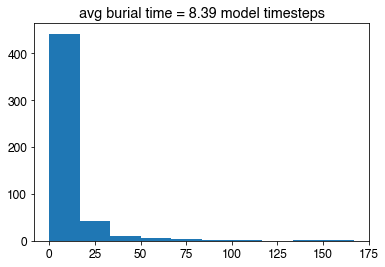

In [37]:
# burialtimes = (bar_heights/bh_sedflux)/(86400)
avg_burialtime = np.average(burialtimes)
plt.hist(burialtimes.ravel(), bins = 10);
plt.title(f'avg burial time = {np.round(avg_burialtime, 2)} model timesteps')
## check this conversion